## Multiple Comparisons in Statistical Tests

While our goal with this course is not to teach you statistics, we do need to take a slight detour to address some common statistical issues that come up in ECoG analyses. First, we'll touch on the problem of **multiple comparisons** ( https://en.wikipedia.org/wiki/Multiple_comparisons_problem ). This refers to the idea that, if you run many statistical tests, you're more likely to get a false positive with increasing numbers of tests. For example, if a subject has 100 electrodes, and we'd like to test whether there's an increase in power at each electrode, some will -- purely by chance -- show an increase in power even if it's not meaningfully correlated with memory. 

The easiest way to correct for multiple comparisons is to set a more stringent threshold for determining significance. Typically, these thresholds are set as <i>p</i> values, which you're likely quite familiar with. The <i>p</i> value is the proportion of test statistic values that, under the null hypothesis, exceed the true test statistic. If too many null values exceed the true value, it's hard to say that the true value is "significant." But if you set the <i>p</i> value to something very small -- as in, almost no null values exceed the true value -- it becomes quite difficult to find a "significant" result. 

<center>
<img src="https://med.stanford.edu/news/all-news/2016/03/misleading-p-values-showing-up-more-often-in-journals/_jcr_content/main/image.img.620.high.jpg" width=500>
</center>

Indeed, the **Bonferonni correction** is a common and simple way to account for the multiple comparisons problem. The basic idea is to take the <i>P</i> value you'd ordinarily use, and divide it by the number of tests you're running. So if usually you'd want a P<0.05 to declare significance, but you run 100 tests, now you'd need a P<0.0005 for significance. This is a very conservative way to control for multiple comparisons (strictly, Bonferonni correction controls for the "familywise error" rate). If a test survives Bonferonni correction (and assuming other assumptions about the test were also met), that's a strong indication that there's something real there, and you can make some conclusions about it. 

You'll also see "False Discover Rate" controlling procedures, or **FDR correction**, in the ECoG literature. These are less conservative tests that let you screen for effects in large amounts of data, but do not offer the same kind of strict control that Bonferonni does (therefore, be more cautious in your interpretation of the "significant" effects.). A common FDR procedure is called "Benjamini Hochberg," though there are several algorithms with unique properties. 

Many types of correction can be applied using the stats toolbox within MNE. Let's explore a few of these now, and use them on real data. 

In [6]:
#First, let's load up some data
import numpy as np
pvals = np.load('R1001P_pvals.npy')  #with dimensions frequencies X electrodes X time bins

Text(0,0.5,'Count')

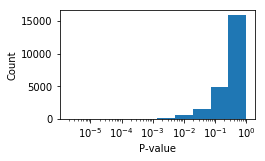

In [25]:
#Let's take a look at the distribution of these p-values
%matplotlib inline
from pylab import *

#Plot a histogram of pvalues on a log scale
figure(figsize=(3.5, 2)); ax=subplot(111)
_, bins, _ = plt.hist(pvals.ravel(), bins=10, alpha=0)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
hist(pvals.ravel(), bins=logbins, color='C0')
xscale('log'); xlabel('P-value'); ylabel('Count')

It's clear that there aren't many P-values less than 0.001. Would any of these survive Bonferonni correction?

Perhaps testing individual P-values across all timepoints, frequencies, and electrodes isn't the best approach. What if we restricted ourselves to running tests at the electrode level, for a given time window of interest?

In [32]:
#Reload the raw power values so we can re-run some tests
rec = np.load('R1001P_recalled.npy')
pows = np.load('R1001P_pows.npy')

#pows are dimensions freqs X events X electrodes X time bins

#Let's average powers into across the 400-1100 ms window, which begins after ERP effects die out but not so long as to include irrelevant activity
#Furthermore, let's only analyze the theta frequencies, which were the first 5 (trust me)
avg_pow = np.mean(np.mean(pows[:5, :, :, 4:11], 0), -1)

#avg_pow should be an events X electrodes array. Excellent! Let's do our 2-sample T-test on these averaged values
from scipy.stats import ttest_ind
ts, ps = ttest_ind(avg_pow[rec==1, :], avg_pow[rec==0, :], axis=0, equal_var=False)

In [45]:
#If we did an uncorrected test, what would we find?
sig_elecs = ps<0.05

print(ps<0.05)

[False False False False  True  True False  True False False False False
  True  True  True  True False False False False  True False False False
 False False False False False False False False False False False False
  True False False False False False False False  True False False False
 False False False False False False False False False False False  True
 False False  True False False  True False False False False False  True]


In [54]:
#What about Bonferonni correction?
from mne.stats import bonferroni_correction

reject, pval_cor = bonferroni_correction(ps, 0.05)

print(reject)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


Still, no electrodes survive Bonferroni correction! Is it too conservative? What about FDR correction?

In [55]:
from mne.stats import fdr_correction

reject, pval_cor = fdr_correction(ps, 0.05)  #by default, this implements Benjamini-Hochberg with a 0.05 threshold. 

print(reject)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


Still nothing! That means, if we didn't come at this question with a hypothesis about a specific region, there are not statistically significant effects of memory on spectral power in the theta band. (Note that we do have "marginally" significant effects at the 0.1 level, but at this point, we call that "fishing."

## Permutation testing

The statistical tests we have discussed so far are **parametric**, meaning that they rely on models of data established by a finite number of parameters. For instance, the t-test models our data as normal distributions, with fixed means and standard deviations. These tests are often powerful and extremely fast, but they do have their drawbacks: Namely, they rely on a number of assumptions about the underlying data, including their distributional forms and **independence**. Many parametric tests assume that datapoints or distributions are uncorrelated or unrelated to each other; if this isn't actually true, you can end up with a false positive!

There are several **nonparametric** tests that do not make assumptions about the distributional form of your data. Today, we're going to implement a general approach to nonparametric testing, called a **permutation test**. Permutation tests (also called randomization tests) make no assumptions about the data; instead, they literally create the null distribution against which to compare your test statistic, instead of modeling it based on parameters derived from your data. In fact, there are many ways in which the general idea of resampling statistics are applied throughout data science -- learning about permutation tests is a good way to get some initial exposure to these methods. 

How to do a permutation test: 

1. **Decide what you want to test**: Are you looking for the difference in means between two distributions? A difference in their variance? Whether the sum of one distribution is significantly greater than another? A permutation test can, in theory, handle anything you throw at it. 
2. **Compute your "true" statistic.** For whatever you decided in step (1), compute that number. It could be a difference score, a t-statistic, an F-statistic, or anything else. 
3. **Randomly shuffle your data.** For example, if you're testing something between two distributions, randomly swap data between those distributions, but <i>maintain the original size of the distributions</i>. Remember, a permnutation test is about keeping everything exactly the same, except for the data values themselves. 
4. For each random shuffle in step (3), **recompute your test statistic**. 
5. **Repeat steps 3-4 many times.** There's no strict rule on exactly how many times, and the more shuffles you do, the precise P-value you can get. But more shuffles means more compute time, and it may quickly become intractable. 1000 shuffles is common and a good rule-of-thumb, but typically you'll need at least several hundred. 
6. **Compare true statistic to null distribution.** Typically this takes the form of computing a p-value or a z-score.

#### Example

Let's try this out on our power data from R1001P. Yesterday, we ran a 2-sample (or "independent") t-test to ask whether there was a significant difference in power between remembered and not-remembered conditions. But in doing so, we violated an assumption of the test: The two distributions are not actually independent! Recalled and not-recalled trials can occur right after one another, and EEG data is autocorrelated in time. While, in practice, this violation might not be a huge deal, it was technically inappropriate to use this test for statistical inference. A permutation test allows us to keep everything above-board. 

In [87]:
#Reload the raw power values and recalled array
rec = np.load('R1001P_recalled.npy')
pows = np.load('R1001P_pows.npy')

#pows are dimensions freqs X events X electrodes X time bins

#Let's average powers into across the 400-1100 ms window, which begins after ERP effects die out but not so long as to include irrelevant activity
#Furthermore, let's only analyze the theta frequencies, which were the first 5 (trust me)
avg_pow = np.mean(np.mean(pows[:5, :, :, 4:11], 0), -1)

#Step 1: We'd like to test the difference in mean theta power between rec and not-rec distributions.
#Step 2: Compute the true difference in means

diff_mu = np.mean(avg_pow[rec==1, :], 0)-np.mean(avg_pow[rec==0, :], 0)

#Step 3, 4, 5: Randomly shuffle data between rec and not-rec groups, and recompute test statistic (x 1000)

num_rec = np.sum(rec)  #we need to know how many data points fall in each group
idx_vec = np.arange(len(rec))  #vector of indices for later shuffling

from numpy.random import shuffle  #note that this function shuffles in-place

null_mus = []
for i in range(1000):  #iterating over shuffles
    shuffle(idx_vec)
    null_rec = idx_vec[:num_rec]   #creating null groups of 'rec' and 'not-rec'
    null_nrec = idx_vec[num_rec:]
    diff_mu_null = np.mean(avg_pow[null_rec, :], 0)-np.mean(avg_pow[null_nrec, :], 0)  #recomputing the test statistic
    null_mus.append(diff_mu_null)   
null_mus = np.array(null_mus)

Text(0,0.5,'Count')

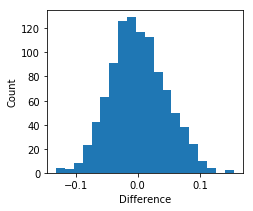

In [88]:
#Inspect the null distribution to see that everything worked as intended
figure(figsize=(3.5, 3)); ax=subplot(111)
hist(null_mus[:, 11], 20)
xlabel('Difference')
ylabel('Count')

Looks pretty good! Null distributions don't *have* to look any particular way, but if you see very strange-looking distributions, or an unreasonable range of values, you may want to go back and check your code. (Or at least understand why the distribution should look that way.)

One-sided: 0.20499999999999996
Two-sided: 0.4099999999999999
-0.8162115837852147


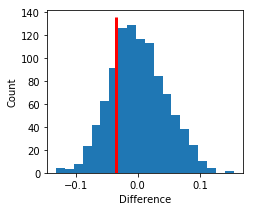

In [89]:
#Step 6: Get a p-vaue or z-score

#Plot where the true value falls relative to the null distribution
figure(figsize=(3.5, 3)); ax=subplot(111)
hist(null_mus[:, 11], 20)
xlabel('Difference')
ylabel('Count')
vlines([diff_mu[11]], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='r', linewidths=3)

#Quantify with a p-value. If we're doing a 2-sided test, multiply the resulting p-value by 2. 
pval = np.sum(null_mus[:, 11]>diff_mu[11])/float(null_mus.shape[0])
print('One-sided: '+str(1.-pval))
print('Two-sided: '+str((1.-pval)*2))

#Quantify with a z-score
Z = (diff_mu[11]-np.mean(null_mus[:, 11]))/np.std(null_mus[:, 11])
print(Z)

The true value falls pretty close to the middle, which is why it has a nonsignificant p-value and a z-score of -0.744. Nothing significant here!

Text(0,0.5,'T-stat')

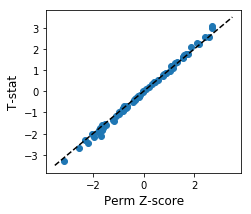

In [96]:
#How do the permutation results compare to our original t-test? An easy way to check would be to compare the permutation z-score to the t-statistics 
#(with large enough samples, these statistics are essentially the same).

#Compute z-score for each electrode
zs = []
for i in range(len(diff_mu)):
    zs.append((diff_mu[i]-np.mean(null_mus[:, i]))/np.std(null_mus[:, i]))

#Plot results
figure(figsize=(3.5, 3)); ax=subplot(111)
plot(zs, ts, 'o')
plot([-3.5, 3.5], [-3.5, 3.5], 'k--')
xlabel('Perm Z-score', fontsize=12)
ylabel('T-stat', fontsize=12)

The t-stats and z-scores look very similar, meaning that the independence violation probably wasn't a big deal. There is a hint that the t-stats might have been slightly overstating our effects at the low end of the range. 

**Exercise: Generalize the approach above to run a permutation t-test. How do the results compare to the original parametric t-test? How do they compare to the difference in means permutation test?**

**Exercise: How does the correlation of between the t-test and the permutation z-scores change as a function of the number of random shuffles?**

### Cluster testing 

In [57]:
from mne.stats import permutation_cluster_test